Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_confl

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

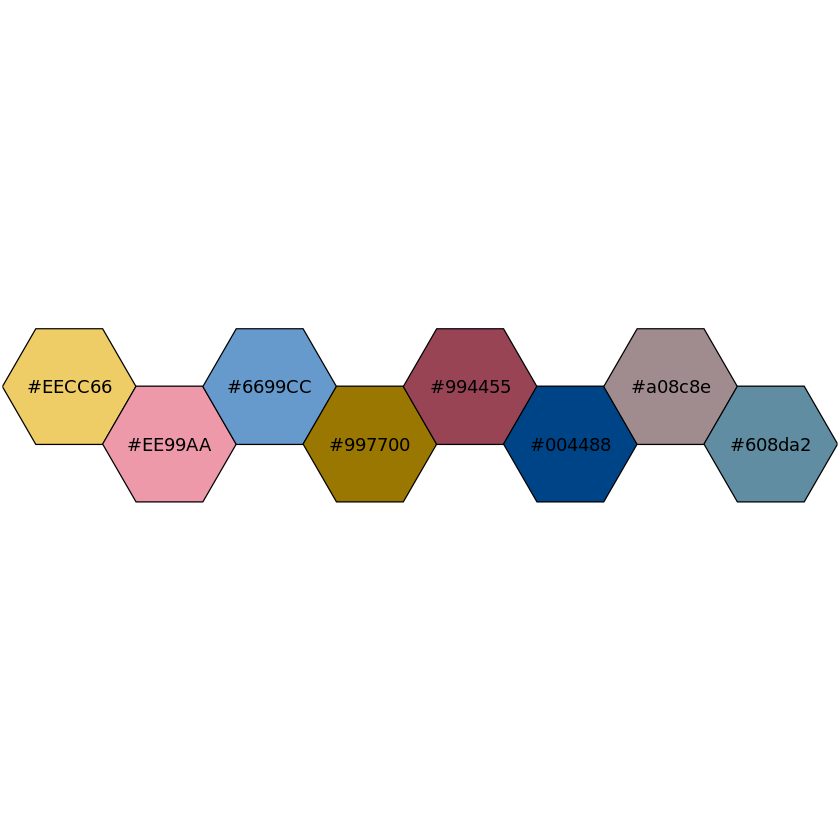

In [1]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [2]:
lst_fisher_genus <- readRDS(paste0(INT_SPL, "lst_fisher_genus.Rdata"))
lst_fisher_species <- readRDS(paste0(INT_SPL, "lst_fisher_species.Rdata"))
Asp_genus_RPM <- readRDS(paste0(INT_SPL, "Asp_genus_RPM.Rdata"))

In [3]:
ann_NA <- data.frame(sample_short = c("A15","A14"), p.value = c(150,150), label = "not available",
                       origin = factor("Plasma ss-cfDNA", levels = c("BAL ss-cfDNA", "Plasma ss-cfDNA")))

ann_NA_2 <- data.frame(sample_short = c("A15","A14","A15","A14"), p.value = 150, label = "not available",
                       origin = factor("Plasma ss-cfDNA", levels = c("BAL ss-cfDNA", "Plasma ss-cfDNA")), 
                      db = c("dREM.260", "dREM.260", "cRE.21", "cRE.21"))

In [4]:
genus_db="EPRSFv64MCAspDM"
species_db="EPRSc2"

In [5]:
dt_fisher_species <- lst_fisher_species[["EPRSc2"]] %>% 
    melt(id.vars = c('taxName','count','db','threshold','sample','control_type','origin'), 
                 variable.name = "test_type", value.name = "p.value") %>% 
        filter(grepl(sample, pattern = "asp$")) %>% 
        mutate(sample = factor(x = sample, levels = c(rev(unique(as.factor(lst_fisher_species[[1]]$sample)))))) %>% 
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(!is.na(p.value)) %>%  
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        mutate(shape_test = ifelse(taxName == "Aspergillus fumigatus", 
                                 yes = taxName, no = "Other Aspergillus species")) %>% 
        mutate(col_test = ifelse(test_type == "fisher.t.int" & p.value <= 0.001, 
                                 yes = "p < 0.001, internal control",
                          ifelse(test_type == "fisher.t.ext" & p.value <= 0.001, 
                                 yes = "p < 0.001, external controls", 
                          ifelse(test_type == "fisher.t.int" & p.value > 0.001, 
                                 yes = "p > 0.001, internal control", 
                          ifelse(test_type == "fisher.t.ext" & p.value > 0.001, 
                                 yes = "p > 0.001, external controls", no = NA))))) %>% 
        filter(grepl(col_test, pattern = "internal control")) %>% 
        mutate(p.value = -log10(p.value)) 

plt_fisher_species <- dt_fisher_species %>% 
        ggplot(aes(x = p.value, y = sample_short, col = col_test)) + 
            geom_hline(yintercept = 2.5, linetype = 1 , color = "black", linewidth = 1) + 
            geom_hline(yintercept = seq(1.5,6.5,1), linetype = 1 , color = "black", linewidth = 0.15) + 
            geom_vline(xintercept = -log10(0.001), linetype="dotted", color = "black", size=1.5) + 
            geom_point(aes(shape = shape_test), size = 4, alpha = 0.5) + 
            geom_point(aes(shape = shape_test), data = . %>% filter(grepl(col_test, pattern = "p < 0.001")), size = 4, alpha = 1) +
            facet_grid(cols = vars(origin), 
                       drop = TRUE, scales = "free_y", space = "free") + 
            ylab("") + xlab("mean p-value Fisher's exact\n-log10") + 
            theme_bw() + labs(color = "mean p-value Fisher's exact", shape = "Species") + 
            scale_color_manual(values = c("p < 0.001, internal control" = colors_mc[6], 
                                          "p < 0.001, external controls" = colors_mc[5], 
                                          "p > 0.001, internal control" = "darkgrey",
                                          "p > 0.001, external controls" = "darkgrey"),
                              labels = c(expression(p <= 0.001 * ", internal control"), 
                                      #expression(p <= 0.001 * ", external controls"), 
                                      "p > 0.001, internal control"#, 
                                      #"p > 0.001, external controls"
                                     )) +
            scale_shape_manual(values = c(17,15)) + 
            scale_y_discrete(limits=rev) +
            guides(color = guide_legend(order = 1), shape = guide_legend(order = 2)) + 
            geom_text(data = ann_NA, label = "not available", col = "black", size = 5) +
            geom_text(data = dt_fisher_species %>% filter(p.value == Inf) %>% 
                      mutate(p.value = 225), label = "Inf", col = colors_mc[5], size = 5) + xlim(0,300) + 
            ggtitle("Aspergillus species level identification", subtitle = "cRE.21; CT=0.4")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [6]:
df_fisher_genus <- lst_fisher_genus[["EPRSFv64MCAspDM"]] %>% 
    melt(id.vars = c('db','sample','Asp_genus_count','total_read_count','control_type','origin'), 
                 variable.name = "test_type", value.name = "p.value") %>%   
        filter(grepl(sample, pattern = "asp$")) %>% 
        mutate(sample = factor(x = sample, levels = c(rev(unique(as.factor(lst_fisher_genus[[1]]$sample)))))) %>% 
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(!is.na(p.value)) %>%  
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        
        mutate(col_test = ifelse(test_type == "fisher.t.int" & p.value <= 0.001, 
                                 yes = "p < 0.001, internal control",
                          ifelse(test_type == "fisher.t.ext" & p.value <= 0.001, 
                                 yes = "p < 0.001, external controls", 
                          ifelse(test_type == "fisher.t.int" & p.value > 0.001, 
                                 yes = "p > 0.001, internal control", 
                          ifelse(test_type == "fisher.t.ext" & p.value > 0.001, 
                                 yes = "p > 0.001, external controls", no = NA))))) %>% 
        filter(grepl(col_test, pattern = "internal control")) %>% 
        mutate(p.value = -log10(p.value)) %>% 
        mutate(shape_test = "Aspergillus                  ")  

plt_fisher_genus <- df_fisher_genus %>% 
        ggplot(aes(x = p.value, y = sample_short, col = col_test)) + 
            geom_hline(yintercept = 2.5, linetype = 1 , color = "black", linewidth = 0.4) + 
            geom_hline(yintercept = seq(1.5,6.5,1), linetype = 1 , color = "black", linewidth = 0.15) + 
            geom_vline(xintercept = -log10(0.001), linetype="dotted", color = "black", linewidth=1.5) + 
            geom_point(aes(shape = shape_test), size = 4, alpha = 0.5) + 
            geom_point(aes(shape = shape_test), data = . %>% filter(grepl(col_test, pattern = "p < 0.001")), size = 4, alpha = 1) +
            facet_grid(cols = vars(origin), 
                       drop = TRUE, scales = "free_y", space = "free") + 
            ylab("") + xlab("mean p-value Fisher's exact\n-log10") + 
            theme_bw() + labs(color = "mean p-value Fisher's exact", shape = "Genus") + 
            scale_color_manual(values = c("p < 0.001, internal control" = colors_mc[6], 
                                          "p < 0.001, external controls" = colors_mc[5], 
                                          "p > 0.001, internal control" = "darkgrey",
                                          "p > 0.001, external controls" = "darkgrey"),
                              labels = c(expression(p <= 0.001 * ", internal control"), 
                                      #expression(p <= 0.001 * ", external controls"), 
                                      "p > 0.001, internal control"#, 
                                      #"p > 0.001, external controls"
                                     )) +
            scale_y_discrete(limits=rev) +
            guides(color = guide_legend(order = 1), shape = guide_legend(order = 2)) + 
            geom_text(data = df_fisher_genus %>% filter(p.value == Inf) %>% 
                      mutate(p.value = 225), label = "Inf", col = colors_mc[5], size = 5) +
            geom_text(data = ann_NA, label = "not available", col = "black", size = 5) +
            xlim(0,300) + 
            #guides(col = "none") +
            ggtitle("Aspergillus genus level identification", subtitle = "dREM.260; CT=0.9")

In [7]:
genus_RPM_plots <- list()
for (fav_db in dbs_sel_min){
    if (fav_db == "EPRSc2"){print(fav_db); tmp_genus_threshold = "conf0.8"}
    if (fav_db == "EPRSFv64MCAspDM"){print(fav_db); tmp_genus_threshold = "conf0.9"}
                
    print(tmp_genus_threshold)
    genus_RPM_plots[[fav_db]] <- Asp_genus_RPM[[tmp_genus_threshold]] %>% 
        melt(varnames = c("db", "sample"), value.name = "value") %>%  
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(grepl(sample, pattern = "asp$")) %>% 
        filter(db == fav_db) %>% 
        mutate(sample = ifelse(grepl(sample, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                ifelse(grepl(sample, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control"))) %>% 
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        mutate(RPM = "Reads Per Million") %>% 
        mutate(origin = ifelse(sample == "plasma", yes = "Plasma ss-cfDNA",
                        ifelse(sample == "BAL", yes = "BAL ss-cfDNA", no = NA))) %>% 
        ggplot(aes(x = value, y = sample_short)) +
            geom_segment(aes(x=0, xend=value, y=sample_short, yend=sample_short, color = RPM), size = 2, alpha = 0.7) +
            geom_point(aes(color = RPM), size = 4,shape = 19) + 
            scale_color_manual(values = colors_mc[[4]],
                              guide = guide_legend(override.aes = list(shape = c(NA)))) + 
            facet_grid(cols = vars(origin)) + 
            scale_y_discrete(limits=rev) + 
            xlab("Fractional Abundance") + ylab("") + theme_bw() +
            geom_hline(yintercept = 2.5, linetype = 1 , color = "black", size = 0.4) +
            geom_hline(yintercept = seq(1.5,6.5,1), linetype = 1 , color = "black", size = 0.15) + 
            labs(color = "Fractional Abundance") + xlim(0,60) + 
            #ggtitle(tmp_title, subtitle = tmp_subtitle) + 
            geom_text(data = ann_NA_2 %>% mutate(value = 30), label = "not available", col = "black", size = 3)
}

[1] "EPRSc2"
[1] "conf0.8"
[1] "EPRSFv64MCAspDM"
[1] "conf0.9"


In [8]:
ann_txt1 <- data.frame(sample_short = "A14", db = "dREM.260", label = "Inf", p.value = 0, 
                       origin = factor("BAL ss-cfDNA", levels = c("BAL ss-cfDNA", "Plasma ss-cfDNA")))

df_comp_genus <- rbind(lst_fisher_genus[["EPRSFv64MCAspDM"]], lst_fisher_genus[["EPRSc2"]]) %>% 
    mutate(db = factor(db, levels = c("EPRSFv64MCAspDM", "EPRSc2"))) %>% 
    melt(id.vars = c('db','sample','Asp_genus_count','total_read_count','control_type','origin'), 
                 variable.name = "test_type", value.name = "p.value") %>%   
        filter(grepl(sample, pattern = "asp$")) %>% 
        mutate(sample = factor(x = sample, levels = c(rev(unique(
            as.factor(lst_fisher_genus[[1]]$sample)))))) %>% 
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(!is.na(p.value)) %>%  
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        
        mutate(col_test = ifelse(test_type == "fisher.t.int" & p.value <= 0.001, 
                                 yes = "p < 0.001, internal control",
                          ifelse(test_type == "fisher.t.ext" & p.value <= 0.001, 
                                 yes = "p < 0.001, external controls", 
                          ifelse(test_type == "fisher.t.int" & p.value > 0.001, 
                                 yes = "p > 0.001, internal control", 
                          ifelse(test_type == "fisher.t.ext" & p.value > 0.001, 
                                 yes = "p > 0.001, external controls", no = NA))))) %>% 
        filter(grepl(col_test, pattern = "external control")) %>% 
        mutate(p.value = -log10(p.value)) %>%  
        mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
        mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db)))  %>% 
        mutate(db = factor(db, levels = c("dREM.260", "cRE.21")))

comp_genus <- df_comp_genus %>% 
        ggplot(aes(x = db, y = sample_short)) + 
            geom_hline(yintercept = 2.5, linetype = 1 , color = "black", linewidth = 0.4) +
            geom_hline(yintercept = seq(1.5,6.5,1), linetype = 1 , color = "black", linewidth = 0.15) + 
            geom_point(aes(col = col_test, size = p.value), col = NA) + 
            geom_point(data = . %>% filter(grepl(col_test, pattern = "p < 0.001, external controls")),
                      aes(col = col_test, size = p.value)) + 
            facet_grid(cols = vars(origin), 
                       drop = TRUE, scales = "free_y", space = "free") + 
            scale_color_manual(values = c("p < 0.001, internal control" = colors_mc[6], 
                                          "p < 0.001, external controls" = colors_mc[5], 
                                          "p > 0.001, internal control" = "darkgrey",
                                          "p > 0.001, external controls" = "darkgrey"),
                           labels = c(expression(p <= 0.001 * ", internal control"), 
                                      #expression(p <= 0.001 * ", external controls"), 
                                      "p > 0.001, internal control"#, 
                                      #"p > 0.001, external controls"
                                     )) +
            labs(size = "mean p-value Fisher's exact\n-log10", col = "") + ggtitle("Aspergillus genus level identification") + 
            scale_y_discrete(limits=rev) + theme_bw() + ylab("") + xlab("") + 
            theme(axis.text.x = element_text(),
                 panel.grid.minor.x = element_blank(), panel.grid.major.x = element_blank()) + 
            geom_text(data = df_comp_genus %>% filter(p.value == Inf), label = "Inf", col = colors_mc[5], size = 5) +
            geom_text(data = ann_NA_2, label = "not available", col = "black", size = 5) +
            geom_text(data = df_comp_genus %>% filter(col_test == "p > 0.001, external controls"), label = "ns", col = "darkgrey", size = 5, fontface = "italic") +
            geom_rect(aes(xmin = 1.5, xmax = Inf, ymin = -Inf, ymax = Inf), fill = "pink", alpha = 0.02) + 
            guides(color = "none")

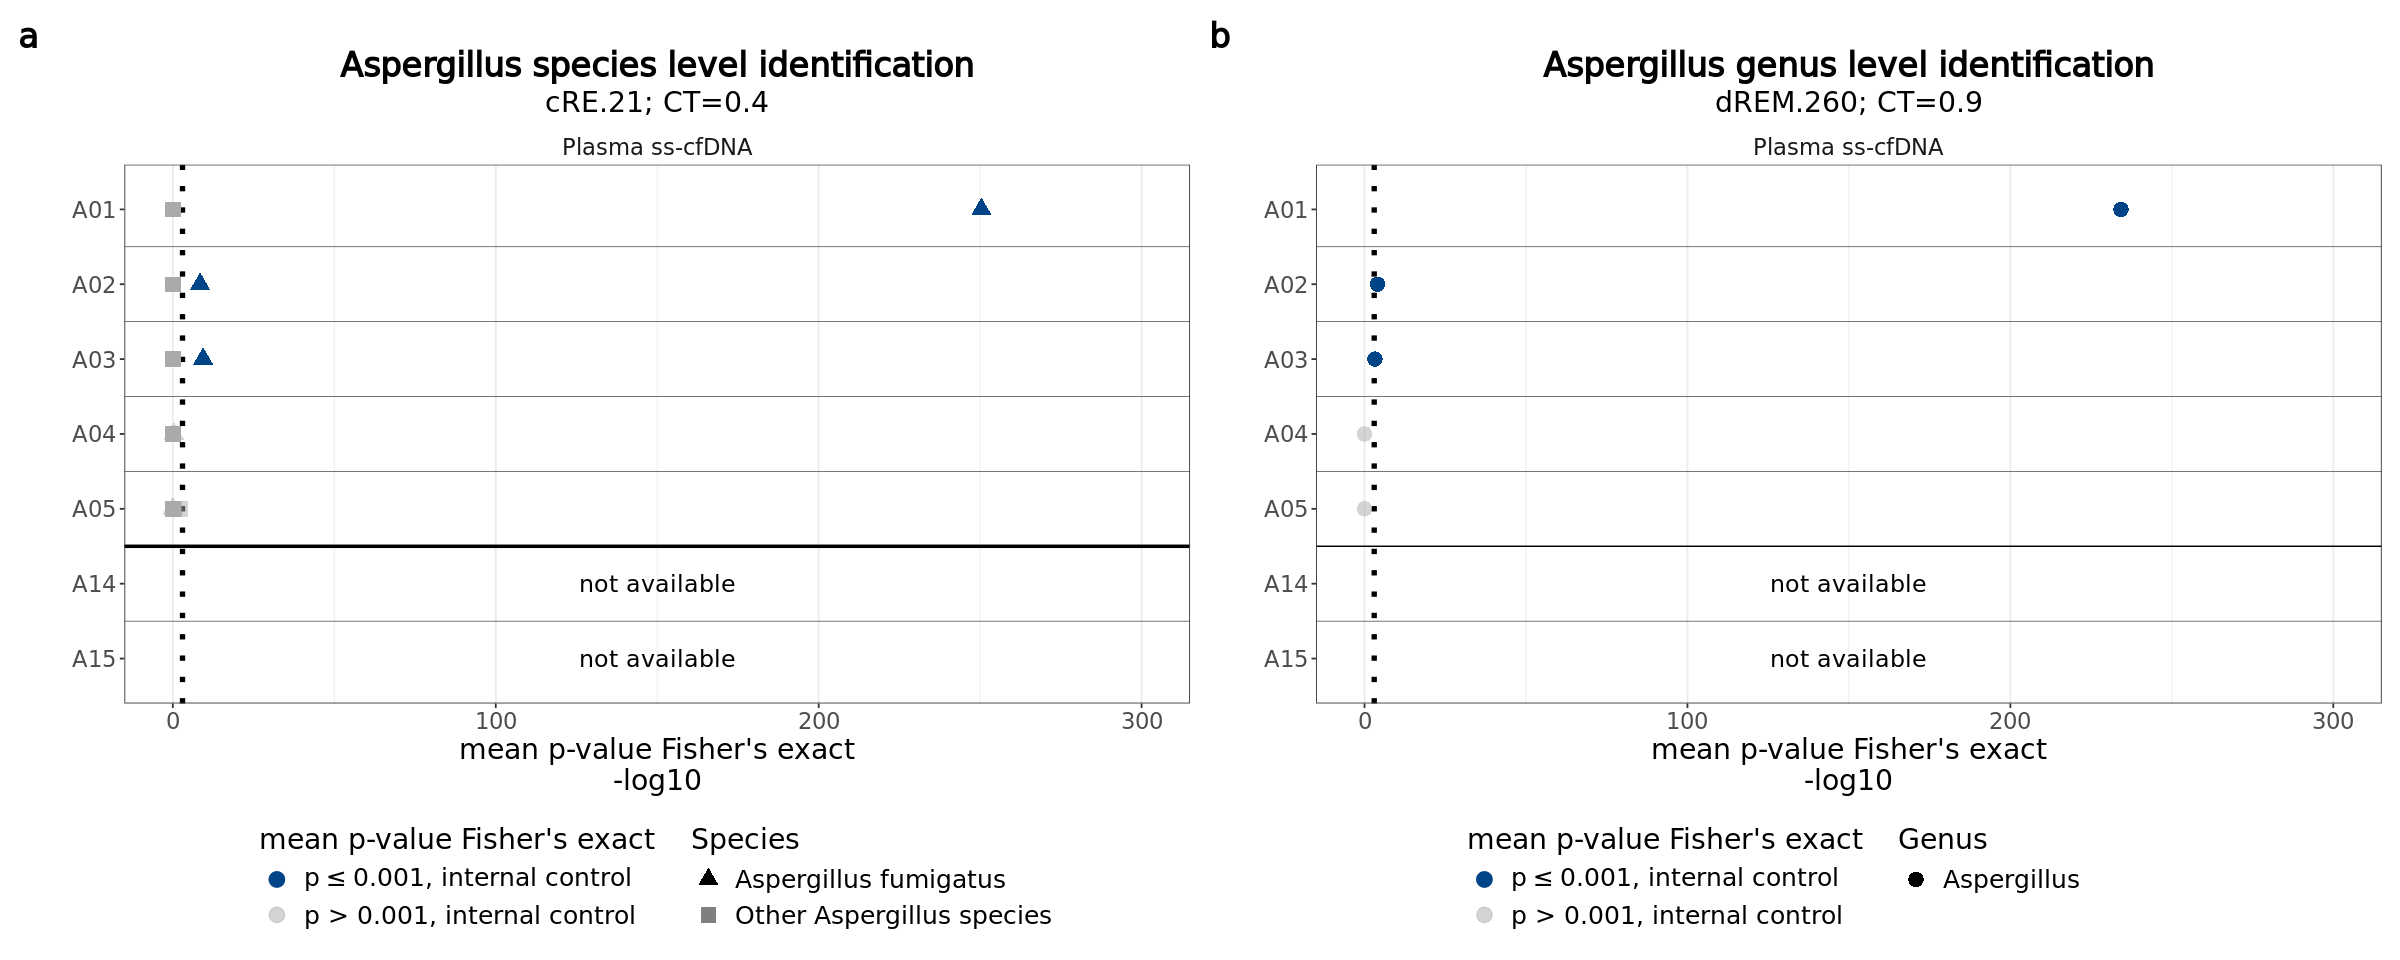

In [9]:
options(repr.plot.width=20, repr.plot.height=8) 
SuplFig12 <- 
    plt_fisher_species + plt_fisher_genus +  
        plot_layout(ncol = 2) &
        plot_annotation(tag_levels = 'a') &
        theme(legend.position='bottom', legend.justification='top', legend.direction = 'vertical',
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5), 
            plot.tag = element_text(face = 'bold', size = 20), 
            strip.background=element_rect(fill="white", color = "white"), 
            panel.grid.minor.y = element_blank(), panel.grid.major.y = element_blank()) 

SuplFig12

ggsave("../../output/suppl_figures/SuplFig12_R.png", 
       SuplFig12, width = 20, height = 8)
ggsave("../../output/suppl_figures/SuplFig12_R.pdf", 
       SuplFig12, width = 20, height = 8)